# **Backtesting Momentum Trading Strategies using OpenBB**

This notebook demonstrates how to perform backtesting of a momentum trading strategy using historical stock price data from OpenBB. A momentum trading strategy involves buying or selling assets based on recent price movements. In this notebook, we will:
- Fetch Historical Stock Data using OpenBB.
- Apply a Momentum Strategy based on moving averages.
- Simulate Trades to backtest the strategy.
- Analyze Performance by comparing the strategy’s returns to a buy-and-hold strategy.

The goal of the analysis is to test the effectiveness of a momentum-based trading strategy over time and to see how it performs in comparison to a simple buy-and-hold approach.

Author:<br>
[Sanchit Mahajan](https://github.com/SanchitMahajan236)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1FCMR2oFACCP-YciCcvN5qRnh1r1GypzV?usp=sharing)

In [ ]:
!pip install openbb -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openbb import obb

In [4]:
symbols = ['AAPL', 'GOOG', 'MSFT', 'NVDA']
start_date = '2015-01-01'
initial_capital = 10000
short_window = 40
long_window = 100
dataframes = []

for symbol in symbols:
    try:
        data = obb.equity.price.historical(
            symbol=symbol,
            start_date=start_date,
            provider="yfinance"
        ).to_df()
        data['Symbol'] = symbol
        dataframes.append(data)
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {str(e)}")

combined_data = pd.concat(dataframes)
combined_data = combined_data.reset_index()

combined_data.head()

,date,open,high,low,close,volume,split_ratio,dividend,Symbol
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,212818400,0.0,0.0,AAPL
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,257142000,0.0,0.0,AAPL
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,263188400,0.0,0.0,AAPL
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,160423600,0.0,0.0,AAPL
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,237458000,0.0,0.0,AAPL


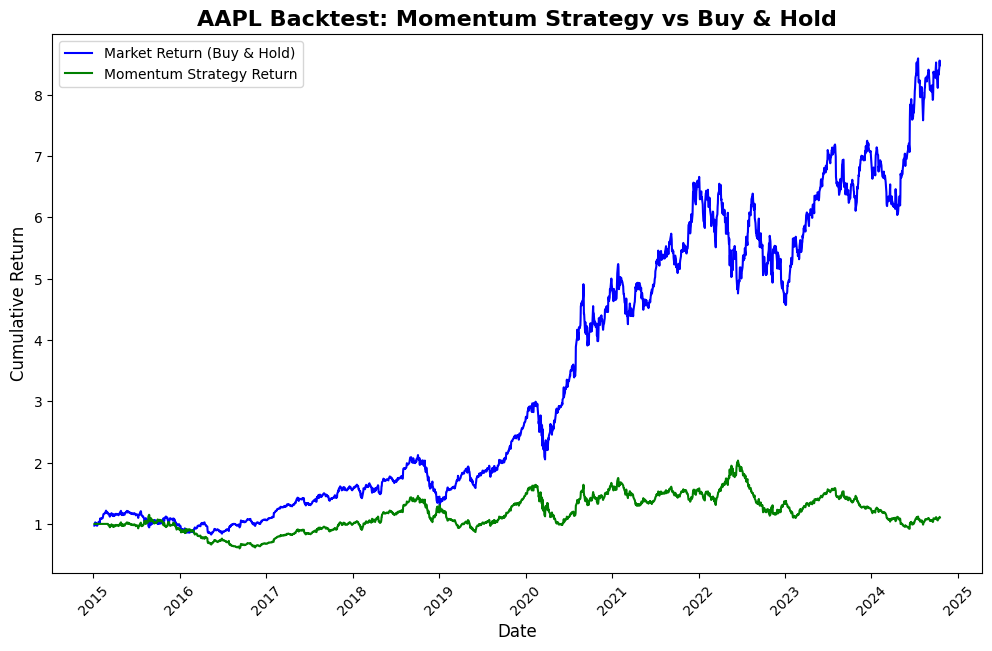

Final portfolio value for AAPL: $11050.08
Total market return for AAPL: 748.00%
Total strategy return for AAPL: 10.50%


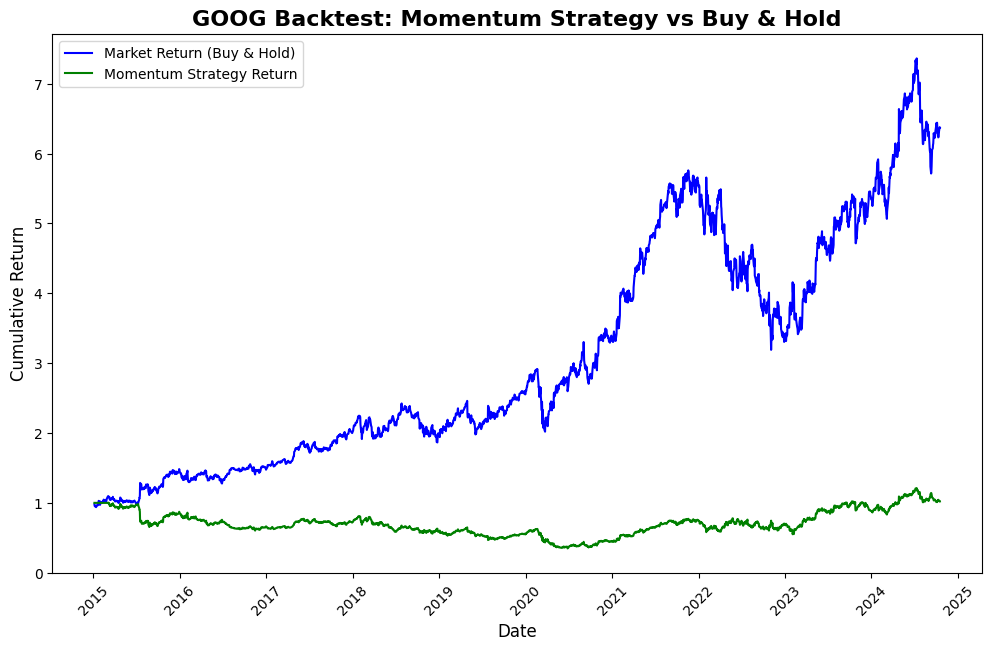

Final portfolio value for GOOG: $10204.69
Total market return for GOOG: 537.17%
Total strategy return for GOOG: 2.05%


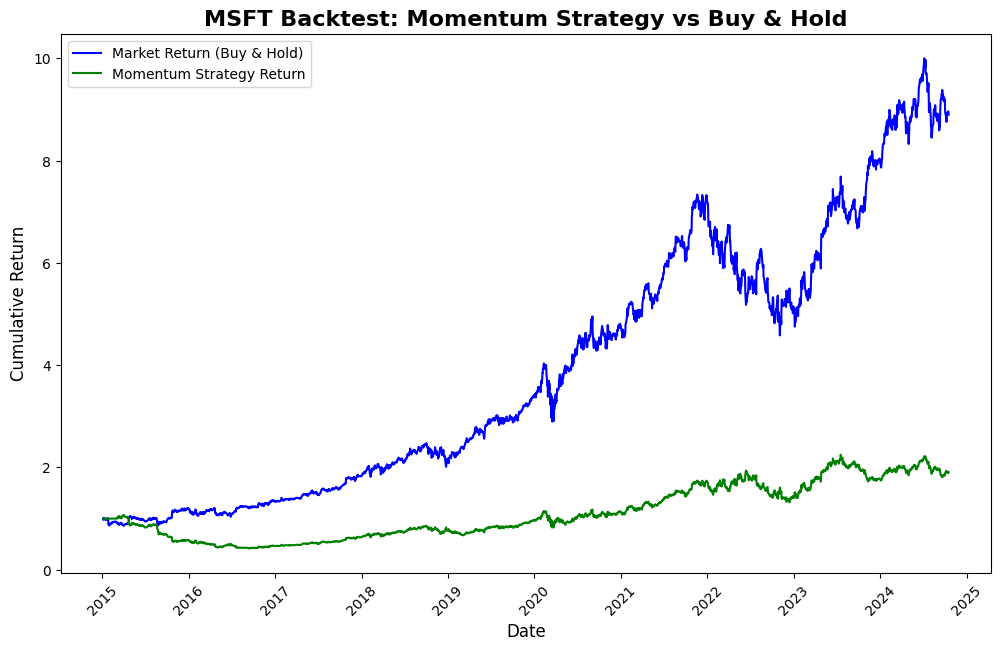

Final portfolio value for MSFT: $19057.30
Total market return for MSFT: 789.91%
Total strategy return for MSFT: 90.57%


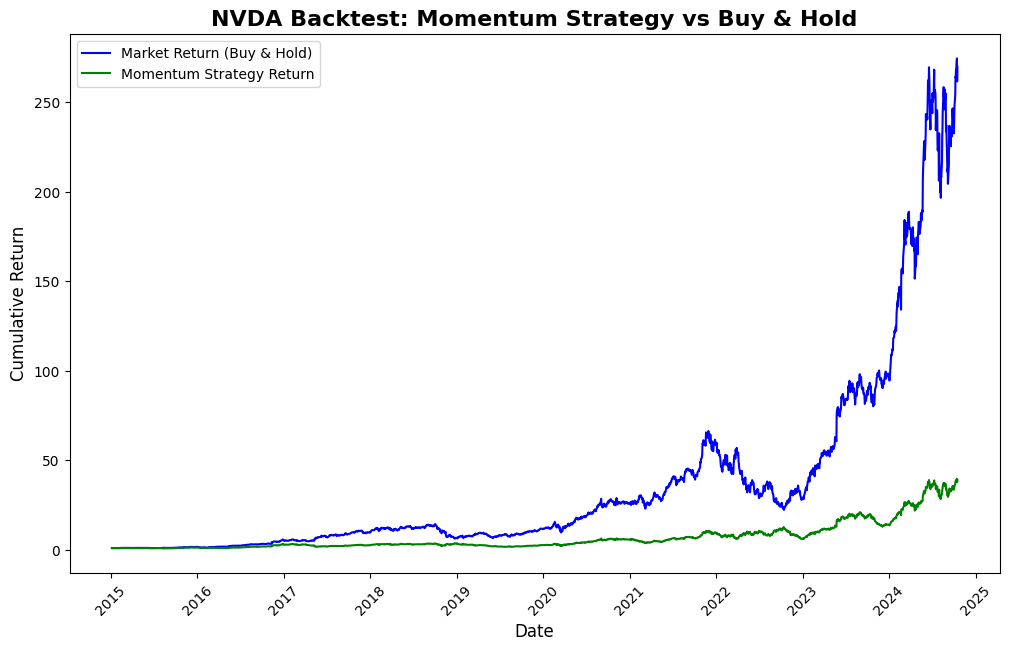

Final portfolio value for NVDA: $390038.95
Total market return for NVDA: 26868.70%
Total strategy return for NVDA: 3800.39%


In [10]:
def momentum_strategy(data, short_window, long_window):
    data['Short MA'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['Long MA'] = data['close'].rolling(window=long_window, min_periods=1).mean()

    data['Signal'] = 0
    signal_values = np.where(
        data['Short MA'][short_window:] > data['Long MA'][short_window:], 1, -1
    )
    data.loc[data.index[short_window:], 'Signal'] = signal_values
    data['Position'] = data['Signal'].shift(1)

    return data

def backtest(data, initial_capital):
    data['Daily Return'] = data['close'].pct_change()
    data['Strategy Return'] = data['Position'] * data['Daily Return']
    data['Cumulative Market Return'] = (1 + data['Daily Return']).cumprod()
    data['Cumulative Strategy Return'] = (1 + data['Strategy Return']).cumprod()
    data['Portfolio Value'] = initial_capital * data['Cumulative Strategy Return']

    return data

def visualize_backtest(data, symbol):
    plt.figure(figsize=(12, 7))

    plt.plot(data['date'], data['Cumulative Market Return'], label='Market Return (Buy & Hold)', color='blue')
    plt.plot(data['date'], data['Cumulative Strategy Return'], label='Momentum Strategy Return', color='green')

    plt.title(f'{symbol} Backtest: Momentum Strategy vs Buy & Hold', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.xticks(rotation=45)

    plt.legend()
    plt.show()

for symbol in symbols:
    stock_data = combined_data[combined_data['Symbol'] == symbol].copy()

    stock_data = momentum_strategy(stock_data, short_window, long_window)
    stock_data = backtest(stock_data, initial_capital)

    visualize_backtest(stock_data, symbol)

    final_portfolio_value = stock_data['Portfolio Value'].iloc[-1]
    print(f"Final portfolio value for {symbol}: ${final_portfolio_value:.2f}")

    total_market_return = stock_data['Cumulative Market Return'].iloc[-1] - 1
    total_strategy_return = stock_data['Cumulative Strategy Return'].iloc[-1] - 1
    print(f"Total market return for {symbol}: {total_market_return * 100:.2f}%")
    print(f"Total strategy return for {symbol}: {total_strategy_return * 100:.2f}%")
    print("="*40)
